In [78]:
# importing libraries
import shap
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score

In [79]:
np.random.seed(20)

In [80]:
# craeting a synthetic dataset
df = pd.DataFrame(data = {
    "Know_python":np.random.choice([0,1],size=1000),
    "Know_gen_ai":np.random.choice([0,1],size=1000),
})

In [81]:
df.head()

,Know_python,Know_gen_ai
0,1,1
1,0,1
2,1,0
3,1,0
4,0,0


In [82]:
# Creating the target variable using or ondition 
df["Placement"] = df.any(axis=1).astype(int)

In [83]:
df.head()

,Know_python,Know_gen_ai,Placement
0,1,1,1
1,0,1,1
2,1,0,1
3,1,0,1
4,0,0,0


In [84]:
print("Python value Count -",df.Know_python.value_counts(normalize=True))
print("--"*20)
print("Gen_ai value Count -",df.Know_gen_ai.value_counts(normalize=True))

Python value Count - Know_python
1    0.516
0    0.484
Name: proportion, dtype: float64
----------------------------------------
Gen_ai value Count - Know_gen_ai
0    0.516
1    0.484
Name: proportion, dtype: float64


In [85]:
# Splittig the data
X = df.drop("Placement",axis=1)
y = df["Placement"]

In [86]:
# Train test split
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=42, stratify=y)

In [87]:
print("X_train_shape",X_train.shape)
print("X_test_shape",X_test.shape)
print("y_train_shape",y_test.shape)
print("y_test_shape",y_test.shape)

X_train_shape (800, 2)
X_test_shape (200, 2)
y_train_shape (200,)
y_test_shape (200,)


In [88]:
print("Python value Count in X_train-",X_train.Know_python.value_counts(normalize=True))
print("--"*20)
print("Gen_ai value Count in X_train-",X_train.Know_gen_ai.value_counts(normalize=True))

Python value Count in X_train- Know_python
1    0.515
0    0.485
Name: proportion, dtype: float64
----------------------------------------
Gen_ai value Count in X_train- Know_gen_ai
0    0.50625
1    0.49375
Name: proportion, dtype: float64


In [89]:
print("y_train value Count -",y_train.value_counts(normalize=True))
print("y_train value Count -",y_test.value_counts(normalize=True))

y_train value Count - Placement
1    0.73375
0    0.26625
Name: proportion, dtype: float64
y_train value Count - Placement
1    0.735
0    0.265
Name: proportion, dtype: float64


In [90]:
# Fiiting the model
model = GradientBoostingClassifier(n_estimators=10, learning_rate=0.05, random_state=42)
model.fit(X_train,y_train)
y_pred = model.predict(X_test)
y_train_pred = model.predict(X_train)
print(" Training data Accuracy Score -",accuracy_score(y_train_pred,y_train))
print(" Testing data Accuracy Score -",accuracy_score(y_test,y_pred))

 Training data Accuracy Score - 1.0
 Testing data Accuracy Score - 1.0


In [91]:
# Applying SHAP on compelte data as Background data
background_data = X_train

In [92]:
X_test

,Know_python,Know_gen_ai
805,1,1
910,1,0
258,0,0
55,1,1
75,1,0
...,...,...
65,1,1
484,0,1
214,1,0
178,0,1


In [93]:
# Extract 4 rows from test data (which have each class represented) as df and add all in one list
row_1 = X_test.loc[[805]] # (1,1)
row_2 = X_test.loc[[910]] # (1,0)
row_3 = X_test.loc[[484]] # (0,1)
row_4 = X_test.loc[[258]] # (1,1)

In [94]:
rows = [row_1, row_2, row_3, row_4]
rows

[     Know_python  Know_gen_ai
 805            1            1,
      Know_python  Know_gen_ai
 910            1            0,
      Know_python  Know_gen_ai
 484            0            1,
      Know_python  Know_gen_ai
 258            0            0]

In [95]:
# Model Explanation using SHAP
explainer = shap.TreeExplainer(
                                model = model,
                                data = background_data, # Full training data as background
                                model_output='probability'
                                )

In [96]:
explainer.expected_value # Average model output over the background dataset in probability space
# have 2 classes but still one expected value as we have binrary classification

np.float64(0.7343836608007343)

In [97]:
# Shap values for the selected rows (1)
row_1

,Know_python,Know_gen_ai
805,1,1


In [98]:
shap_values = explainer(row_1)
shap_values 

.values =
array([[0.05233757, 0.05233757]])

.base_values =
array([0.73438366])

.data =
array([[1, 1]])

In [99]:
# Print the results
display(row_1)
print(f"Row Prediction: {model.predict(row_1).item()}")
print(f"Row Prediction: {model.predict_proba(row_1).item(1)}")
print("**"*50)
print(f"Base Value: {shap_values.base_values.item()}")
print(f"Shap Value: shap_values(Knows_python, Knows_gen_ai) = {shap_values.values.ravel()}")

,Know_python,Know_gen_ai
805,1,1


Row Prediction: 1
Row Prediction: 0.8390588094382317
****************************************************************************************************
Base Value: 0.7343836608007343
Shap Value: shap_values(Knows_python, Knows_gen_ai) = [0.05233757 0.05233757]


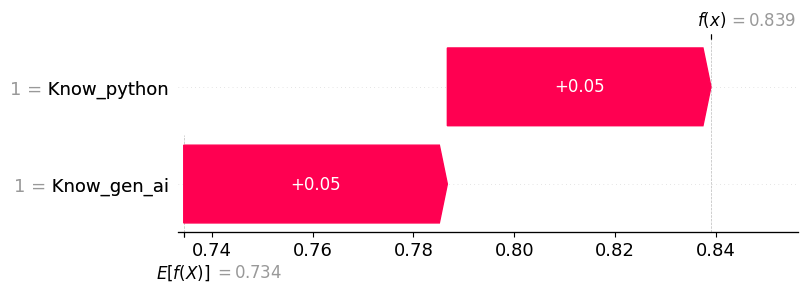

In [100]:
# Converting shap_values from 2d to 1d 
shap.plots.waterfall(shap_values[0])
plt.show()

In [101]:
model.predict_proba(background_data)[:,1].mean() # E[f(X)] -- Base Value 
# f(X) at the top right is the model output for the specific instance


np.float64(0.731867431266179)

In [102]:
model.predict_proba(background_data)[:,1].mean() + 0.05 + 0.05  # Our prediction for row_1

np.float64(0.8318674312661791)

In [119]:
# Build a function so we can try different background datasets


def calculate_and_plot_shap(background_data, test_case):
    
    # make explainer
    explainer = shap.TreeExplainer(model=model,
                                data=background_data,
                                model_output="probability")
    
    # calculate shap values
    shap_values = explainer(test_case)

    # display
    display(test_case)
    print()
    print(f"Row prediction: {model.predict(test_case).item()}")
    print(f"Row prediction: {model.predict_proba(test_case).item(1)}")
    print()
    print(f"Base Value: {shap_values.base_values.item()}")
    print(f"Shap Values (knows_python, knows_genai): {shap_values.values.ravel()}")
    
    # plot waterfall plot
    shap.plots.waterfall(shap_values[0])

In [105]:
row_2

,Know_python,Know_gen_ai
910,1,0


,Know_python,Know_gen_ai
910,1,0



Row prediction: 1
Row prediction: 0.8390588094382317

Base Value: 0.7343836608007343
Shap Values (knows_python, knows_genai): [ 0.31442038 -0.20974523]


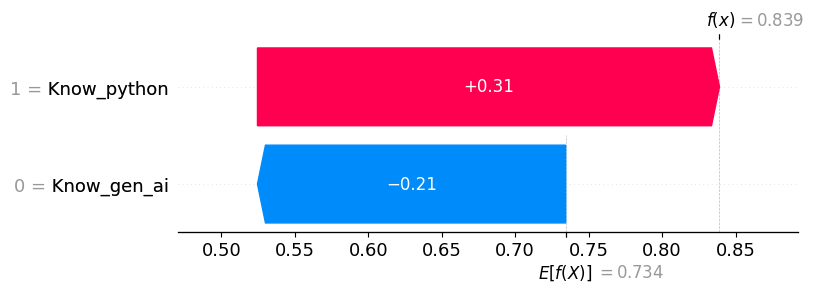

In [120]:
# here our backgound_data is same but our test row / instance changed 
# and that is why our base value remained same and shapely values changed 
calculate_and_plot_shap(background_data,row_2)

,Know_python,Know_gen_ai
484,0,1



Row prediction: 1
Row prediction: 0.8390588094382315

Base Value: 0.7343836608007343
Shap Values (knows_python, knows_genai): [-0.26694848  0.37162363]


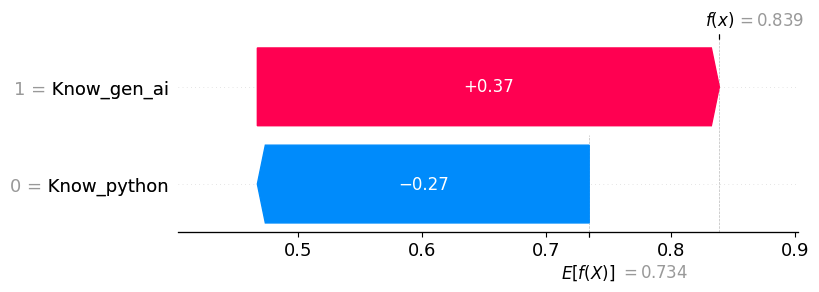

In [121]:
calculate_and_plot_shap(background_data,row_3)

,Know_python,Know_gen_ai
258,0,0



Row prediction: 0
Row prediction: 0.43646208390939595

Base Value: 0.7343836608007343
Shap Values (knows_python, knows_genai): [-0.16103869 -0.13688288]


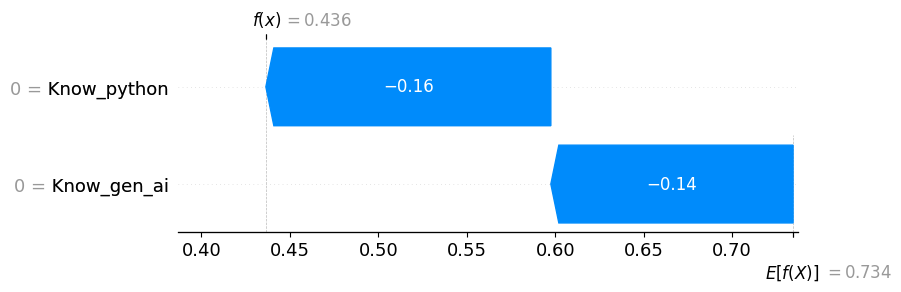

In [122]:
calculate_and_plot_shap(background_data,row_4)

In [123]:
# Using only postive data as background
positive_background = X_train.loc[y_train==1,:]
positive_background

,Know_python,Know_gen_ai
308,1,0
375,0,1
401,1,1
229,1,0
730,1,1
...,...,...
392,1,1
633,1,0
582,0,1
129,0,1


,Know_python,Know_gen_ai
805,1,1



Row prediction: 1
Row prediction: 0.8390588094382317

Base Value: 0.8390588094382315
Shap Values (knows_python, knows_genai): [0. 0.]


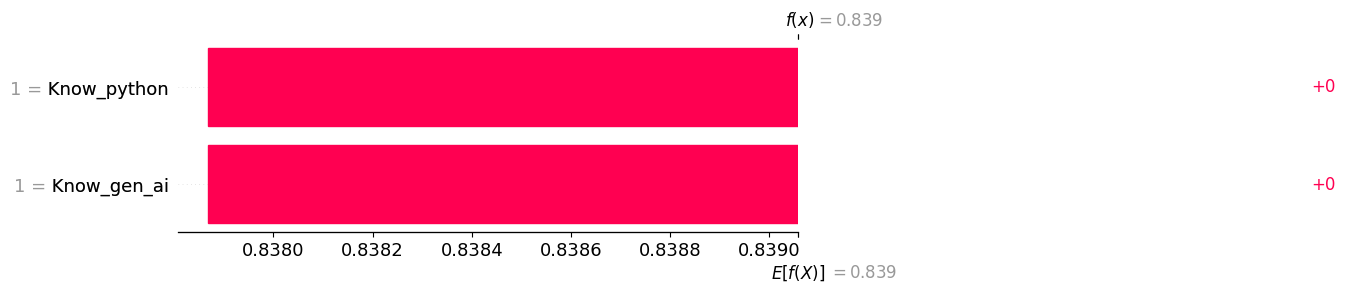

In [ ]:
calculate_and_plot_shap(positive_background,row_1)
# Base value == Prediction value – since all background data points are positive
# Which means basically we are statifyng the eqn - base vaue + sum(shap_values) = 

,Know_python,Know_gen_ai
910,1,0



Row prediction: 1
Row prediction: 0.8390588094382317

Base Value: 0.7343836608007343
Shap Values (knows_python, knows_genai): [ 0.31442038 -0.20974523]


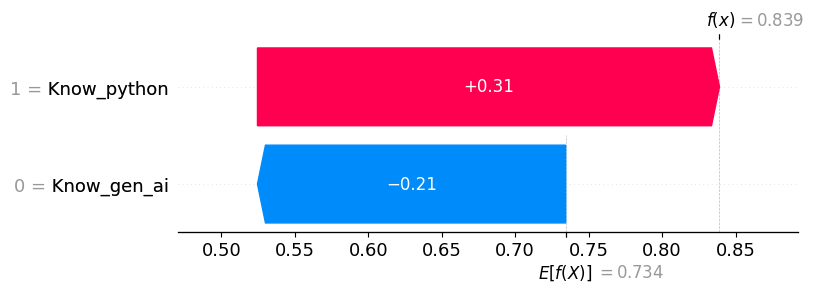

In [125]:
calculate_and_plot_shap(background_data,row_2)